In [1]:
import os
from glob import glob
from tqdm import tqdm
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_curve, auc)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from ml_models.load_data import *

## Classification Task
-> the aim to classify the force levels between low-medium-high classes

**Two methods Implemented below:**
- SVM
- Random Forest classifier

In [2]:
dataset_dir = "/Users/MA_Arash/MA_git/EIT_Thigh_Force_Estimation/Dataset/"

participants = ['P01','P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 
                'P10', 'P11', 'P12', 'P13', 'P14', 'P15']

folds = generate_random_folds(participants=participants, n_test=1, n_folds=5, seed=42)

# Lists for storing metrics across folds
acc_val = []
acc_test = []
fold_names = []

auc_val_list = [] 
auc_test_list = []


## Fold 0

Processing Fold 0
low: 26072, medium: 26072, high: 26151
low: 1849, medium: 1848, high: 1855
Fold 0 | Train participants: ['P01', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P12', 'P13', 'P14', 'P15'] | Validation Accuracy: 0.76



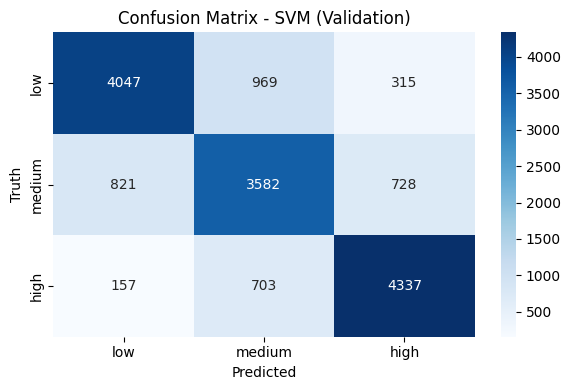

              precision    recall  f1-score   support

         low       0.81      0.76      0.78      5331
      medium       0.68      0.70      0.69      5131
        high       0.81      0.83      0.82      5197

    accuracy                           0.76     15659
   macro avg       0.76      0.76      0.76     15659
weighted avg       0.77      0.76      0.76     15659

Fold 0 | Test participants: ['P11'] | Test Accuracy: 0.33



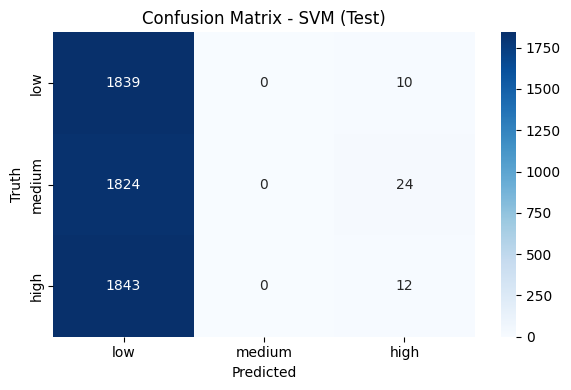

              precision    recall  f1-score   support

         low       0.33      0.99      0.50      1849
      medium       0.00      0.00      0.00      1848
        high       0.26      0.01      0.01      1855

    accuracy                           0.33      5552
   macro avg       0.20      0.33      0.17      5552
weighted avg       0.20      0.33      0.17      5552



/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [3]:
# Fold 0
fold_index = 0
print(f"Processing Fold {fold_index}")

data_set = {
    'Train_set': [os.path.join(dataset_dir, P) for P in folds[fold_index][0]],
    'Test_set': [os.path.join(dataset_dir, P) for P in folds[fold_index][1]]
}


X_train, y_train  = load_dataset(data_set['Train_set'])
y_train_cat, y_train_lbl = assign_classification_labels(y_train)
X_test, y_test = load_dataset(data_set["Test_set"])
y_test_cat, y_test_lbl = assign_classification_labels(y_test)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

# Build the SVM pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1, probability=True, random_state=42))
])

svm_pipeline.fit(X_tr, y_tr)

# Validate the model
y_pred_svm = svm_pipeline.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_svm)
acc_val.append(accuracy_val)
print(f"Fold {fold_index} | Train participants: {folds[fold_index][0]} | Validation Accuracy: {accuracy_val:.2f}\n")


# Compute confusion matrix and classification report for validation set
cm_svm = confusion_matrix(y_val, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["low", "medium", "high"], yticklabels=["low", "medium", "high"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - SVM (Validation)')
plt.tight_layout()
plt.savefig(f"svm_F{fold_index}_validation_confusion_matrix.pdf", format="pdf", dpi=300)
plt.show()
print(classification_report(y_val, y_pred_svm, target_names=["low", "medium", "high"]))



# Evaluate on the test set (Unknown participant)

y_pred_svm_test = svm_pipeline.predict(X_test)
accuracy_test = accuracy_score(y_test_cat, y_pred_svm_test)
acc_test.append(accuracy_test)
fold_names.append("-".join(data_set["Test_set"]))
print(f"Fold {fold_index} | Test participants: {folds[fold_index][1]} | Test Accuracy: {accuracy_test:.2f}\n")

cm_svm_test = confusion_matrix(y_test_cat, y_pred_svm_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["low", "medium", "high"], yticklabels=["low", "medium", "high"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - SVM (Test)')
plt.savefig(f"svm_F{fold_index}_test_confusion_matrix.pdf", format="pdf", dpi=300)
plt.tight_layout()
plt.show()
print(classification_report(y_test_cat, y_pred_svm_test, target_names=["low", "medium", "high"]))


In [ ]:
import joblib
joblib.dump(svm_pipeline, f'svm_F{fold_index}_pipeline_model.pkl')


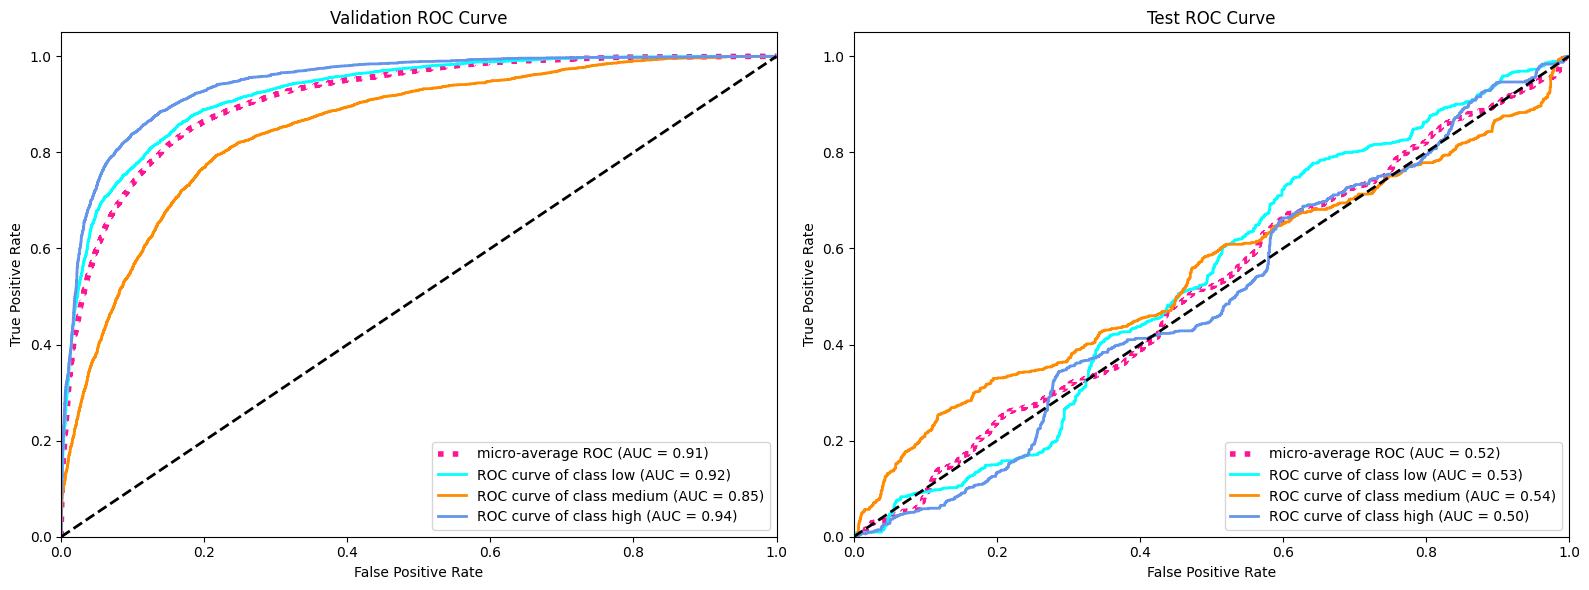

In [4]:
# --- Compute ROC Curves for Test and Validation Set ---

class_names = ["low", "medium", "high"]
n_classes = len(class_names)

# Validation set ROC curves
y_score_val = svm_pipeline.predict_proba(X_val)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

fpr_val = {}
tpr_val = {}
roc_auc_val = {}
for i in range(n_classes):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_bin[:, i], y_score_val[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Compute micro-average ROC for validation
fpr_val["micro"], tpr_val["micro"], _ = roc_curve(y_val_bin.ravel(), y_score_val.ravel())
roc_auc_val["micro"] = auc(fpr_val["micro"], tpr_val["micro"])
# Append the validation micro-average AUC to the global list
auc_val_list.append(roc_auc_val["micro"])

# --- Compute ROC Curves for Test Set ---
y_score_test = svm_pipeline.predict_proba(X_test)
y_test_bin = label_binarize(y_test_cat, classes=[0, 1, 2])

# Compute micro-average ROC for test set
fpr_test = {}
tpr_test = {}
roc_auc_test = {}
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score_test.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
roc_auc_test["micro"] = roc_auc_micro
# Store micro-average ROC in dictionaries for plotting
fpr_test["micro"] = fpr_micro
tpr_test["micro"] = tpr_micro
# Append the test micro-average AUC to the global list
auc_test_list.append(roc_auc_micro)

# Compute class-specific ROC curves for test set
for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    
# --- Plotting ROC Curves for Validation and Test Sets ---
colors = ['aqua', 'darkorange', 'cornflowerblue']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation ROC plot
ax1.plot(fpr_val["micro"], tpr_val["micro"],
         label='micro-average ROC (AUC = {0:0.2f})'.format(roc_auc_val["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr_val[i], tpr_val[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc_val[i]))
ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Validation ROC Curve')
ax1.legend(loc="lower right")

# Test ROC plot
ax2.plot(fpr_test["micro"], tpr_test["micro"],
         label='micro-average ROC (AUC = {0:0.2f})'.format(roc_auc_test["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc_test[i]))
ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Test ROC Curve')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig(f"svm_F{fold_index}_roc_validation_test.pdf", format="pdf", dpi=300)
plt.show()


low: 26291, medium: 26290, high: 26369
low: 1631, medium: 1630, high: 1636
Fold 1 | Train participants: ['P01', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15'] | Validation Accuracy: 0.75



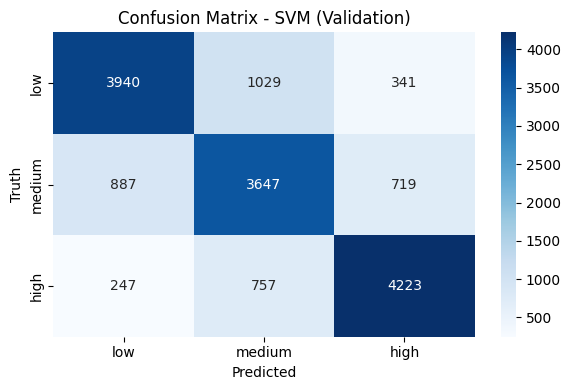

              precision    recall  f1-score   support

         low       0.78      0.74      0.76      5310
      medium       0.67      0.69      0.68      5253
        high       0.80      0.81      0.80      5227

    accuracy                           0.75     15790
   macro avg       0.75      0.75      0.75     15790
weighted avg       0.75      0.75      0.75     15790

Fold 1 | Test participants: ['P02'] | Test Accuracy: 0.37



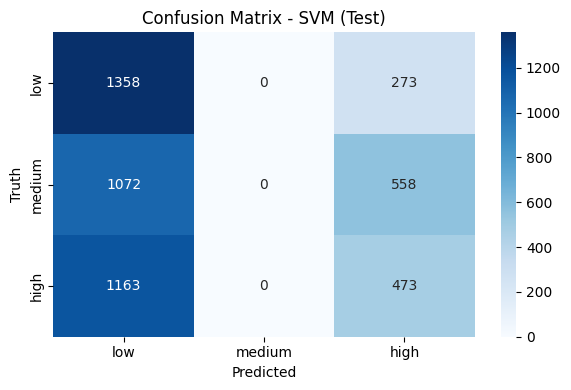

              precision    recall  f1-score   support

         low       0.38      0.83      0.52      1631
      medium       0.00      0.00      0.00      1630
        high       0.36      0.29      0.32      1636

    accuracy                           0.37      4897
   macro avg       0.25      0.37      0.28      4897
weighted avg       0.25      0.37      0.28      4897



/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [5]:
# Fold 1
fold_index = 1

data_set = {
    'Train_set': [os.path.join(dataset_dir, P) for P in folds[fold_index][0]],
    'Test_set': [os.path.join(dataset_dir, P) for P in folds[fold_index][1]]
}


X_train, y_train  = load_dataset(data_set['Train_set'])
y_train_cat, y_train_lbl = assign_classification_labels(y_train)
X_test, y_test = load_dataset(data_set["Test_set"])
y_test_cat, y_test_lbl = assign_classification_labels(y_test)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)

# Build the SVM pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1))
])

svm_pipeline.fit(X_tr, y_tr)

# Validate the model
y_pred_svm = svm_pipeline.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_svm)
acc_val.append(accuracy_val)
print(f"Fold {fold_index} | Train participants: {folds[fold_index][0]} | Validation Accuracy: {accuracy_val:.2f}\n")


# Compute confusion matrix and classification report for validation set
cm_svm = confusion_matrix(y_val, y_pred_svm)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["low", "medium", "high"], yticklabels=["low", "medium", "high"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - SVM (Validation)')
plt.tight_layout()
plt.savefig(f"svm_F{fold_index}_validation_confusion_matrix.pdf", format="pdf", dpi=300)
plt.show()
print(classification_report(y_val, y_pred_svm, target_names=["low", "medium", "high"]))



# Evaluate on the test set (Unknown participant)

y_pred_svm_test = svm_pipeline.predict(X_test)
accuracy_test = accuracy_score(y_test_cat, y_pred_svm_test)
acc_test.append(accuracy_test)
fold_names.append("-".join(data_set["Test_set"]))
print(f"Fold {fold_index} | Test participants: {folds[fold_index][1]} | Test Accuracy: {accuracy_test:.2f}\n")

cm_svm_test = confusion_matrix(y_test_cat, y_pred_svm_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm_svm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=["low", "medium", "high"], yticklabels=["low", "medium", "high"])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - SVM (Test)')
plt.savefig(f"svm_F{fold_index}_test_confusion_matrix.pdf", format="pdf", dpi=300)
plt.tight_layout()
plt.show()
print(classification_report(y_test_cat, y_pred_svm_test, target_names=["low", "medium", "high"]))


In [ ]:
import joblib
joblib.dump(svm_pipeline, f'svm_F{fold_index}_pipeline_model.pkl')


In [6]:
# --- Compute ROC Curves for Test and Validation Set ---

class_names = ["low", "medium", "high"]
n_classes = len(class_names)

# Validation set ROC curves
y_score_val = svm_pipeline.predict_proba(X_val)
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])

fpr_val = {}
tpr_val = {}
roc_auc_val = {}
for i in range(n_classes):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_bin[:, i], y_score_val[:, i])
    roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])

# Compute micro-average ROC for validation
fpr_val["micro"], tpr_val["micro"], _ = roc_curve(y_val_bin.ravel(), y_score_val.ravel())
roc_auc_val["micro"] = auc(fpr_val["micro"], tpr_val["micro"])
# Append the validation micro-average AUC to the global list
auc_val_list.append(roc_auc_val["micro"])

# --- Compute ROC Curves for Test Set ---
y_score_test = svm_pipeline.predict_proba(X_test)
y_test_bin = label_binarize(y_test_cat, classes=[0, 1, 2])

# Compute micro-average ROC for test set
fpr_test = {}
tpr_test = {}
roc_auc_test = {}
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score_test.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
roc_auc_test["micro"] = roc_auc_micro
# Append the test micro-average AUC to the global list
auc_test_list.append(roc_auc_micro)

# Compute class-specific ROC curves for test set
for i in range(n_classes):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    
# --- Plotting ROC Curves for Validation and Test Sets ---
colors = ['aqua', 'darkorange', 'cornflowerblue']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Validation ROC plot
ax1.plot(fpr_val["micro"], tpr_val["micro"],
         label='micro-average ROC (AUC = {0:0.2f})'.format(roc_auc_val["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
for i, color in zip(range(n_classes), colors):
    ax1.plot(fpr_val[i], tpr_val[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc_val[i]))
ax1.plot([0, 1], [0, 1], 'k--', lw=2)
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Validation ROC Curve')
ax1.legend(loc="lower right")

# Test ROC plot
ax2.plot(fpr_test["micro"], tpr_test["micro"],
         label='micro-average ROC (AUC = {0:0.2f})'.format(roc_auc_test["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
for i, color in zip(range(n_classes), colors):
    ax2.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc_test[i]))
ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('Test ROC Curve')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.savefig(f"svm_F{fold_index}_roc_validation_test.pdf", format="pdf", dpi=300)
plt.show()


AttributeError: This 'Pipeline' has no attribute 'predict_proba'

In [ ]:
# --- Boxplot Comparison of Validation and Test AUC across Folds ---

fig, ax = plt.subplots(figsize=(8, 6))
# Combine the two lists into one data structure for the boxplot
data = [auc_val_list, auc_test_list]
ax.boxplot(data, patch_artist=True, labels=["Validation", "Test"])
ax.set_ylabel("Micro-average AUC")
ax.set_title("AUC Distribution for Validation and Test Sets Across Folds[SVM]")
plt.tight_layout()
plt.savefig("svm_auc_val_test_boxplot.pdf", format="pdf", dpi=300)
plt.show()

# Random Forest

Processing Fold 0
low: 26072, medium: 26072, high: 26151
low: 1849, medium: 1848, high: 1855
Fold 0 | Validation Accuracy: 0.99


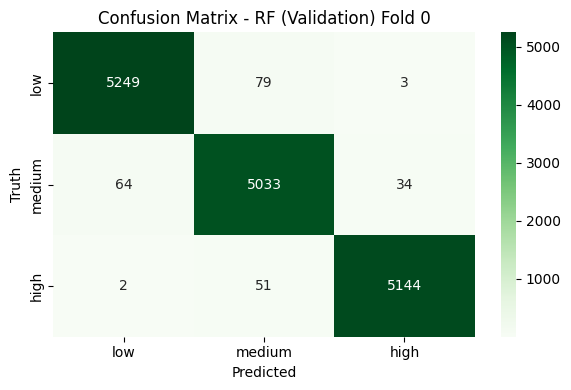

              precision    recall  f1-score   support

         low       0.99      0.98      0.99      5331
      medium       0.97      0.98      0.98      5131
        high       0.99      0.99      0.99      5197

    accuracy                           0.99     15659
   macro avg       0.99      0.99      0.99     15659
weighted avg       0.99      0.99      0.99     15659

Fold 0 | Test Accuracy: 0.33


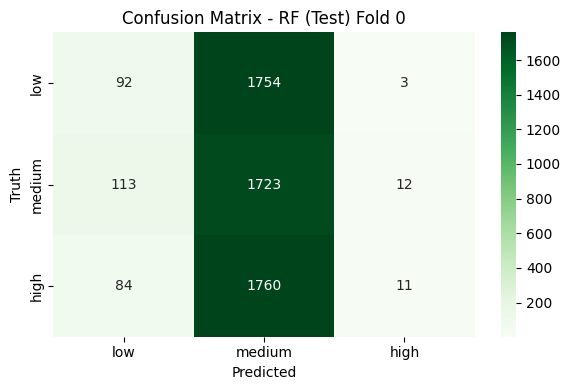

              precision    recall  f1-score   support

         low       0.32      0.05      0.09      1849
      medium       0.33      0.93      0.49      1848
        high       0.42      0.01      0.01      1855

    accuracy                           0.33      5552
   macro avg       0.36      0.33      0.19      5552
weighted avg       0.36      0.33      0.19      5552



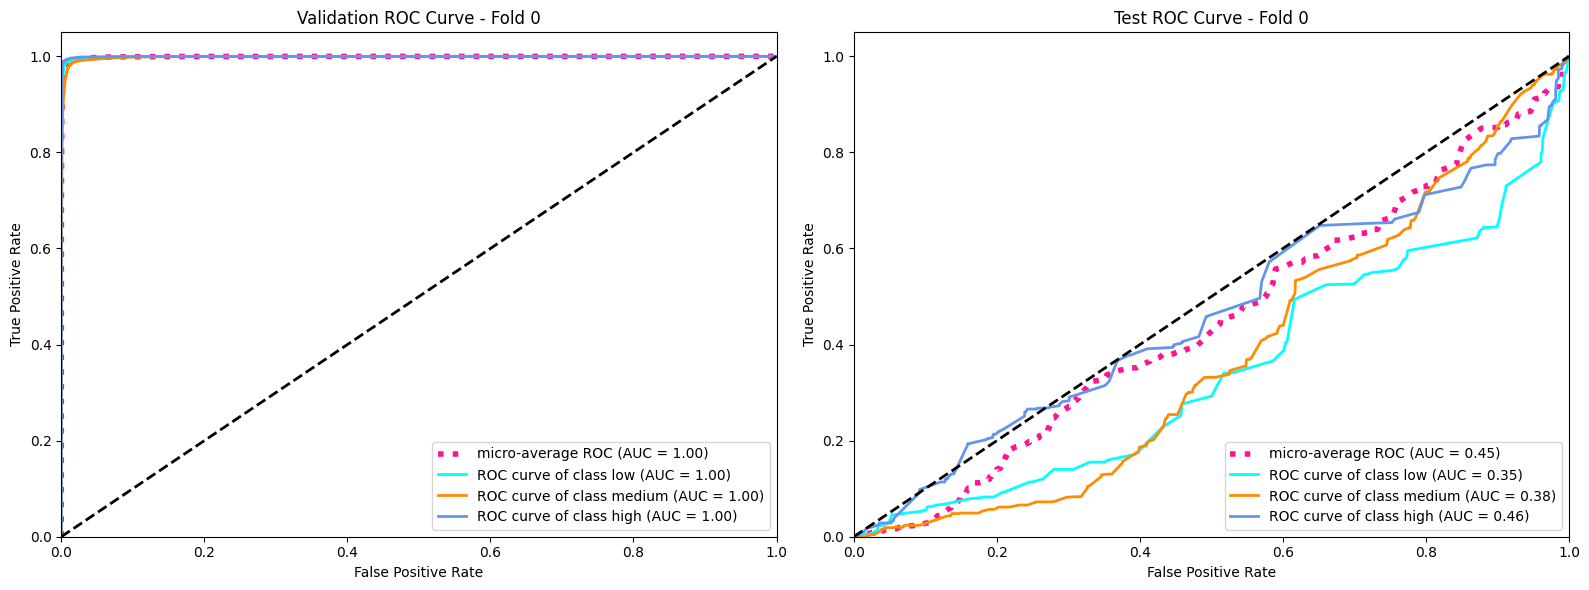

Processing Fold 1
low: 26291, medium: 26290, high: 26369
low: 1631, medium: 1630, high: 1636
Fold 1 | Validation Accuracy: 0.99


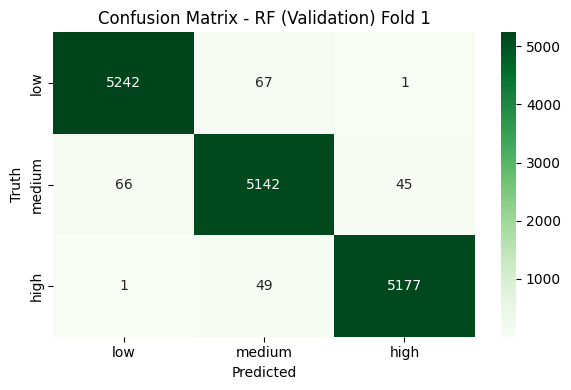

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      5310
      medium       0.98      0.98      0.98      5253
        high       0.99      0.99      0.99      5227

    accuracy                           0.99     15790
   macro avg       0.99      0.99      0.99     15790
weighted avg       0.99      0.99      0.99     15790

Fold 1 | Test Accuracy: 0.31


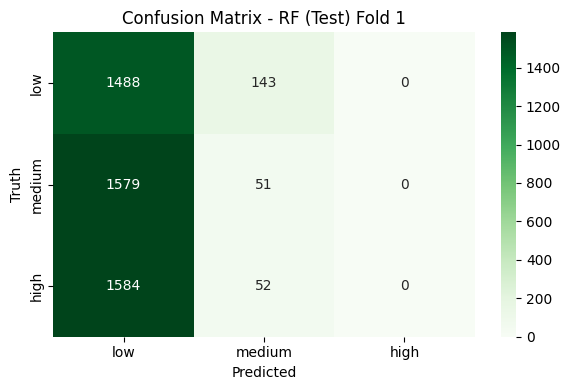

              precision    recall  f1-score   support

         low       0.32      0.91      0.47      1631
      medium       0.21      0.03      0.05      1630
        high       0.00      0.00      0.00      1636

    accuracy                           0.31      4897
   macro avg       0.18      0.31      0.18      4897
weighted avg       0.18      0.31      0.18      4897



/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

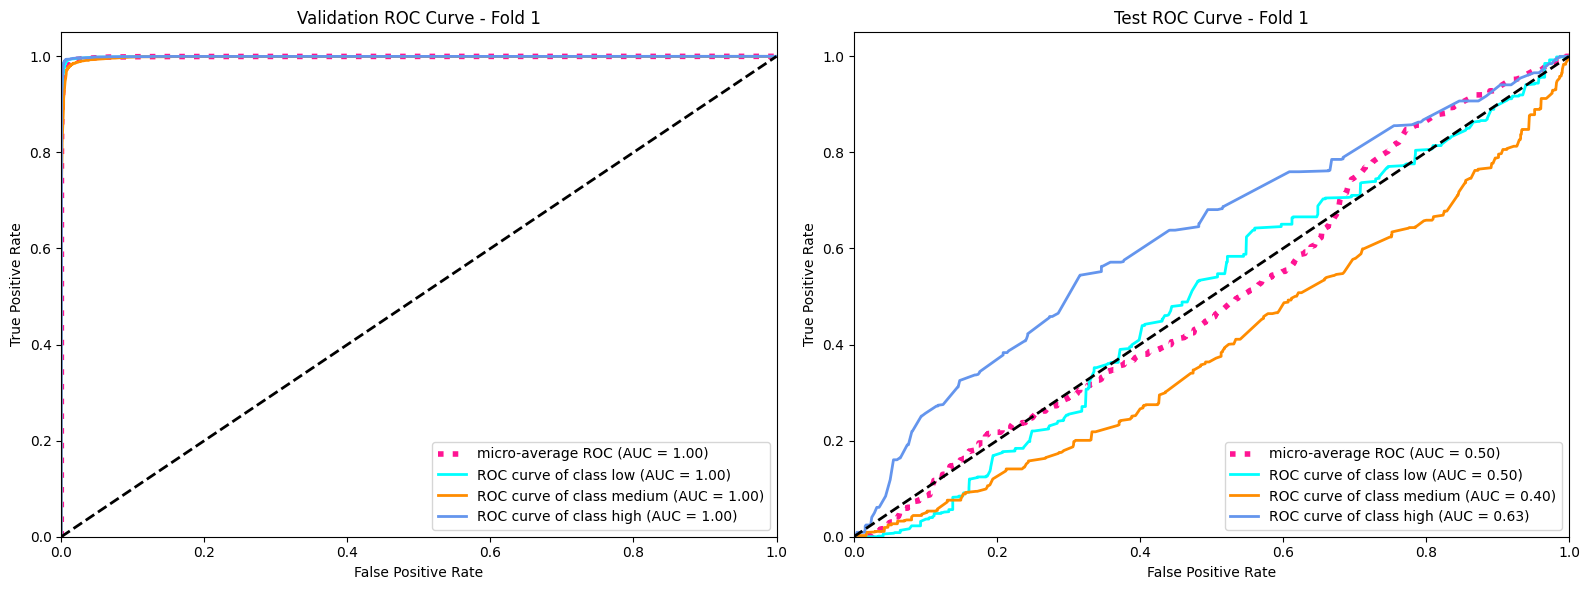

Processing Fold 2
low: 27127, medium: 27127, high: 27208
low: 794, medium: 794, high: 797
Fold 2 | Validation Accuracy: 0.99


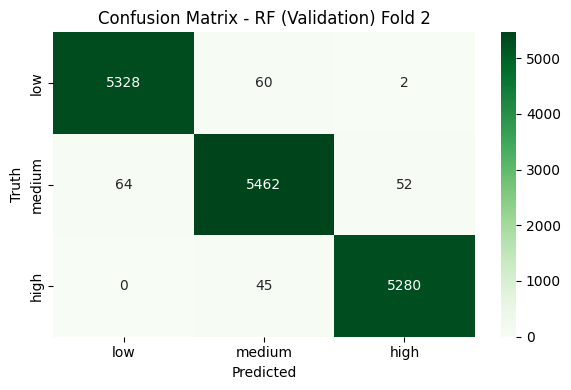

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      5390
      medium       0.98      0.98      0.98      5578
        high       0.99      0.99      0.99      5325

    accuracy                           0.99     16293
   macro avg       0.99      0.99      0.99     16293
weighted avg       0.99      0.99      0.99     16293

Fold 2 | Test Accuracy: 0.33


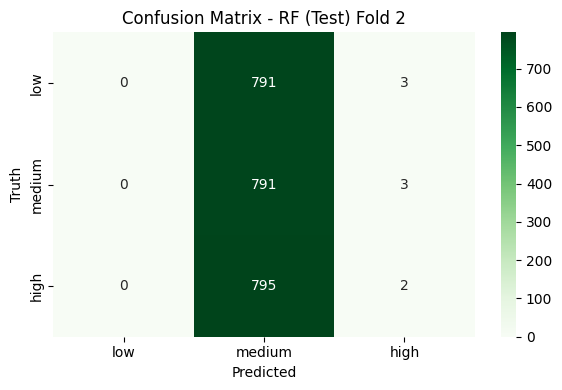

              precision    recall  f1-score   support

         low       0.00      0.00      0.00       794
      medium       0.33      1.00      0.50       794
        high       0.25      0.00      0.00       797

    accuracy                           0.33      2385
   macro avg       0.19      0.33      0.17      2385
weighted avg       0.19      0.33      0.17      2385



/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

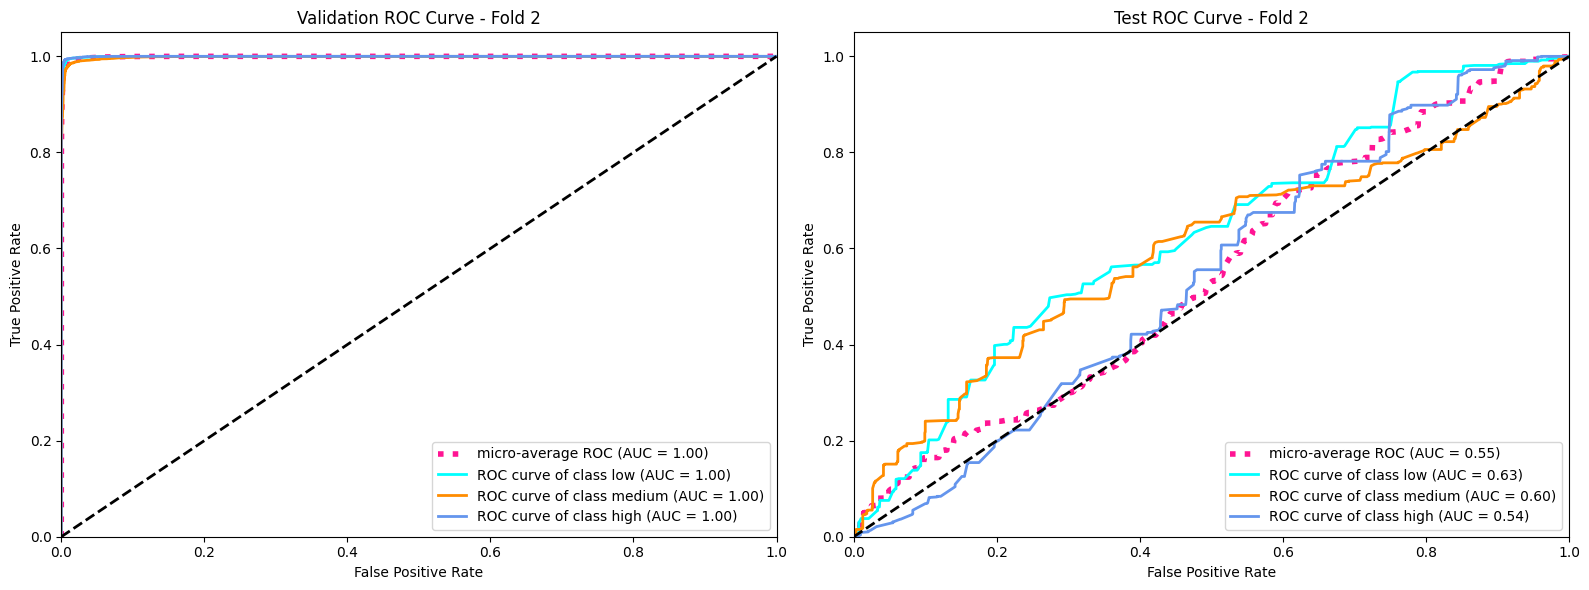

Processing Fold 3
low: 25819, medium: 25819, high: 25897
low: 2102, medium: 2102, high: 2108
Fold 3 | Validation Accuracy: 0.99


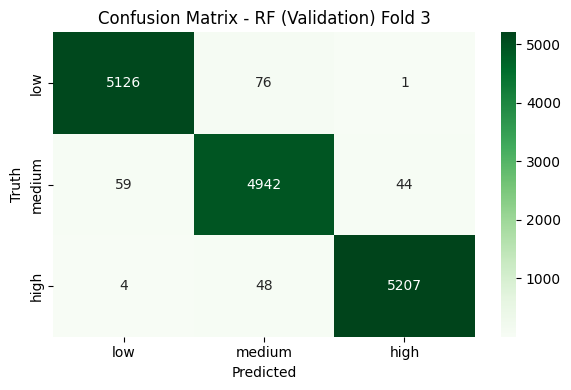

              precision    recall  f1-score   support

         low       0.99      0.99      0.99      5203
      medium       0.98      0.98      0.98      5045
        high       0.99      0.99      0.99      5259

    accuracy                           0.99     15507
   macro avg       0.98      0.98      0.98     15507
weighted avg       0.99      0.99      0.99     15507

Fold 3 | Test Accuracy: 0.32


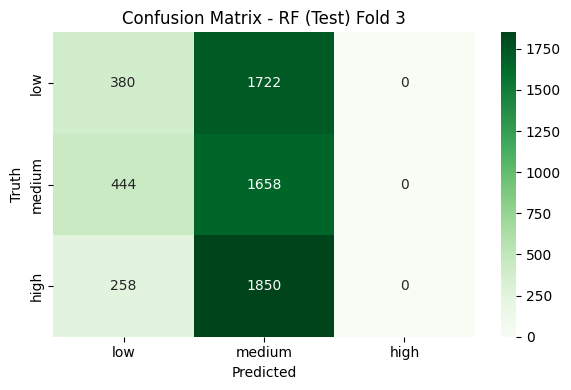

              precision    recall  f1-score   support

         low       0.35      0.18      0.24      2102
      medium       0.32      0.79      0.45      2102
        high       0.00      0.00      0.00      2108

    accuracy                           0.32      6312
   macro avg       0.22      0.32      0.23      6312
weighted avg       0.22      0.32      0.23      6312



/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

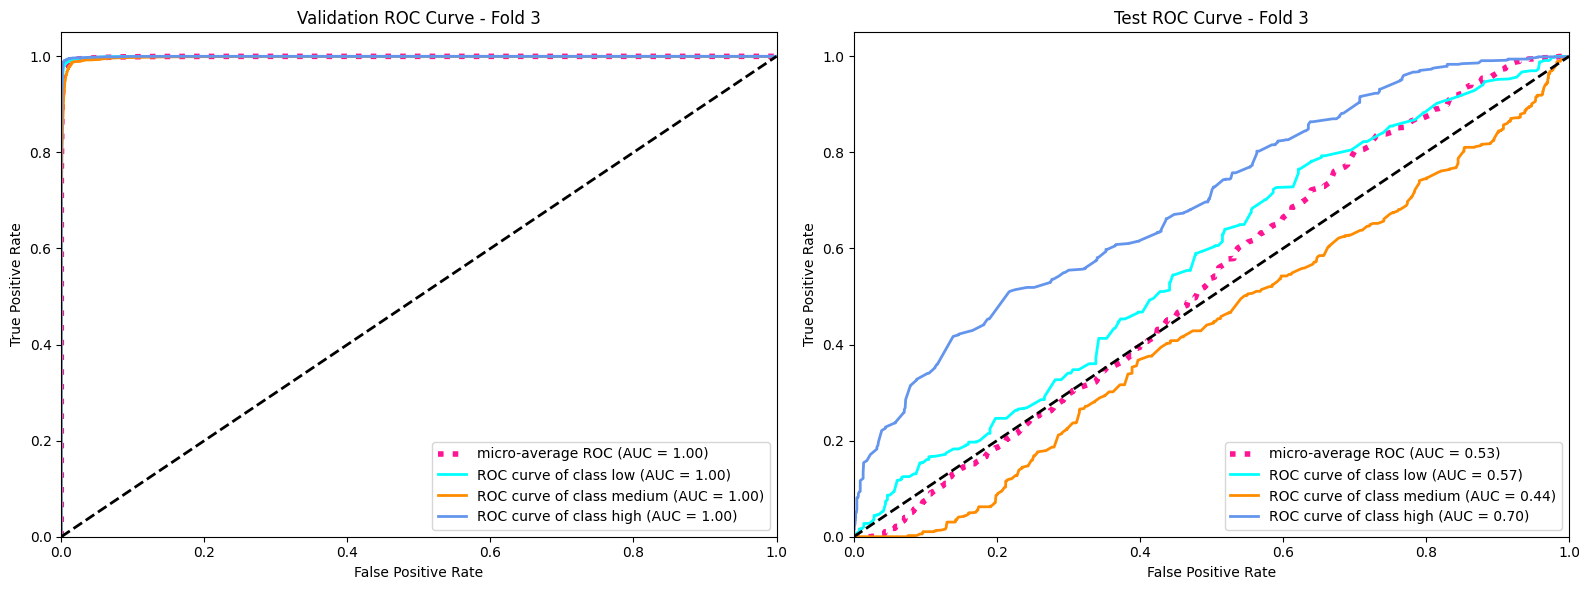

Processing Fold 4
low: 25730, medium: 25730, high: 25808
low: 2191, medium: 2190, high: 2198
Fold 4 | Validation Accuracy: 0.98


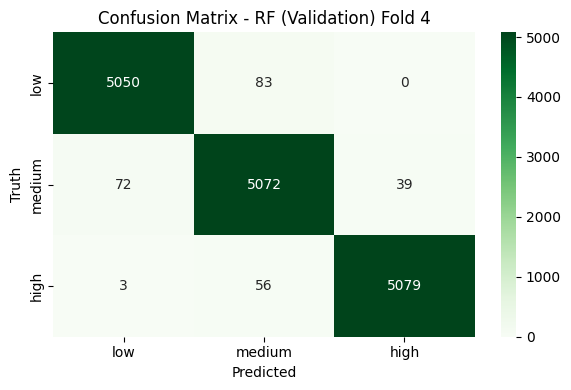

              precision    recall  f1-score   support

         low       0.99      0.98      0.98      5133
      medium       0.97      0.98      0.98      5183
        high       0.99      0.99      0.99      5138

    accuracy                           0.98     15454
   macro avg       0.98      0.98      0.98     15454
weighted avg       0.98      0.98      0.98     15454

Fold 4 | Test Accuracy: 0.29


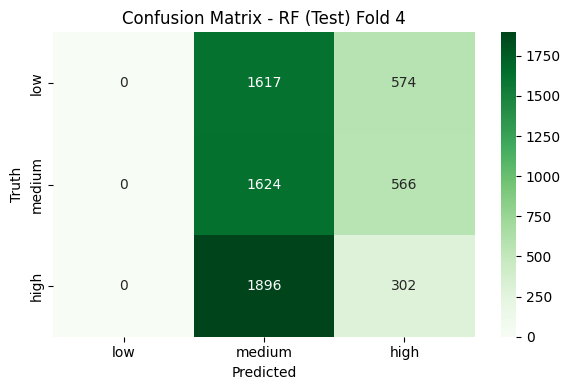

              precision    recall  f1-score   support

         low       0.00      0.00      0.00      2191
      medium       0.32      0.74      0.44      2190
        high       0.21      0.14      0.17      2198

    accuracy                           0.29      6579
   macro avg       0.18      0.29      0.20      6579
weighted avg       0.18      0.29      0.20      6579



/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/arash/anaconda3/envs/MA_Arash/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

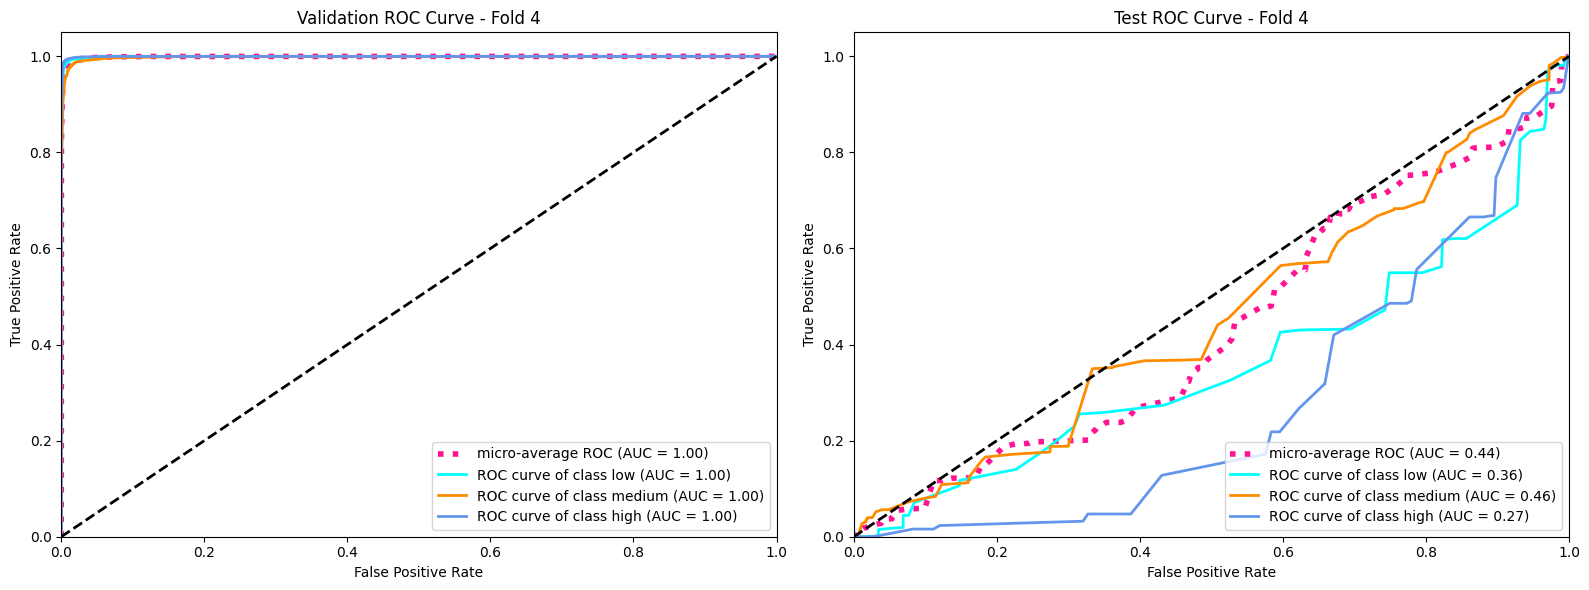

/var/folders/lw/cgx8yj0d66qcfy5dzjjrp6640000gn/T/ipykernel_16999/2849362076.py:155: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data, patch_artist=True, labels=["Validation", "Test"])


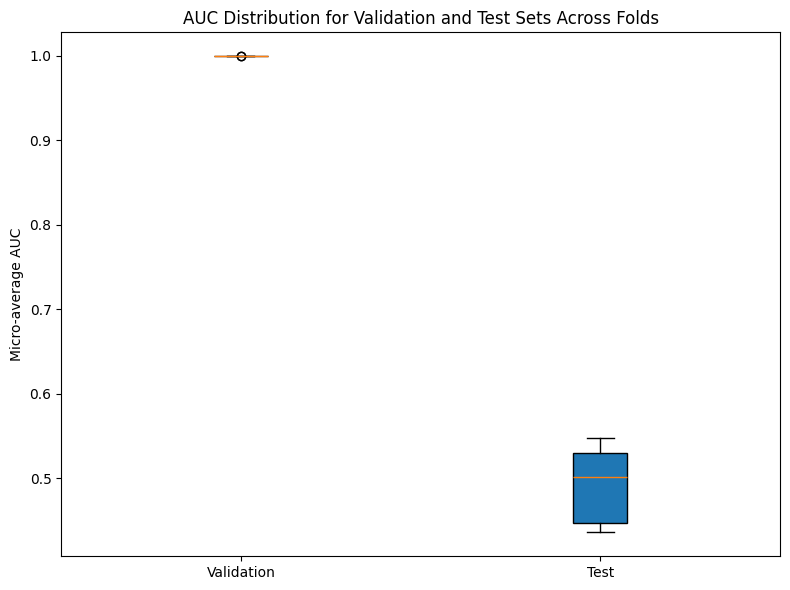

In [ ]:
acc_val_list = []
acc_test_list = []
auc_val_list = []  # micro-average AUC for validation set per fold
auc_test_list = []  # micro-average AUC for test set per fold
fold_names = []
n_folds = len(folds)

# Loop over each fold
for fold_index in range(n_folds):
    print(f"Processing Fold {fold_index}")
    
    # Define dataset paths for current fold
    data_set = {
        'Train_set': [os.path.join(dataset_dir, p) for p in folds[fold_index][0]],
        'Test_set': [os.path.join(dataset_dir, p) for p in folds[fold_index][1]]
    }
    
    # Load datasets and assign classification labels
    X_train, y_train = load_dataset(data_set['Train_set'])
    y_train_cat, y_train_lbl = assign_classification_labels(y_train)
    X_test, y_test = load_dataset(data_set["Test_set"])
    y_test_cat, y_test_lbl = assign_classification_labels(y_test)
    
    # Split the training dataset into train and validation sets
    X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train_cat, test_size=0.2, random_state=42)
    
    # Build the Random Forest pipeline
    rf_pipeline = Pipeline([
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ])
    
    # Train the model
    rf_pipeline.fit(X_tr, y_tr)
    
    # --- Evaluate on Validation Set ---
    y_pred_rf_val = rf_pipeline.predict(X_val)
    accuracy_val_rf = accuracy_score(y_val, y_pred_rf_val)
    acc_val_list.append(accuracy_val_rf)
    print(f"Fold {fold_index} | Validation Accuracy: {accuracy_val_rf:.2f}")
    
    # Confusion matrix and classification report for validation set
    cm_rf_val = confusion_matrix(y_val, y_pred_rf_val)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rf_val, annot=True, fmt="d", cmap="Greens",
                xticklabels=["low", "medium", "high"],
                yticklabels=["low", "medium", "high"])
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.title(f"Confusion Matrix - RF (Validation) Fold {fold_index}")
    plt.tight_layout()
    plt.savefig(f"rf_F{fold_index}_validation_confusion_matrix.pdf", format="pdf", dpi=300)
    plt.show()
    print(classification_report(y_val, y_pred_rf_val, target_names=["low", "medium", "high"]))
    
    # --- Evaluate on Test Set ---
    y_pred_rf_test = rf_pipeline.predict(X_test)
    accuracy_test_rf = accuracy_score(y_test_cat, y_pred_rf_test)
    acc_test_list.append(accuracy_test_rf)
    fold_names.append("-".join(data_set["Test_set"]))
    print(f"Fold {fold_index} | Test Accuracy: {accuracy_test_rf:.2f}")
    
    cm_rf_test = confusion_matrix(y_test_cat, y_pred_rf_test)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_rf_test, annot=True, fmt="d", cmap="Greens",
                xticklabels=["low", "medium", "high"],
                yticklabels=["low", "medium", "high"])
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.title(f"Confusion Matrix - RF (Test) Fold {fold_index}")
    plt.tight_layout()
    plt.savefig(f"rf_F{fold_index}_test_confusion_matrix.pdf", format="pdf", dpi=300)
    plt.show()
    print(classification_report(y_test_cat, y_pred_rf_test, target_names=["low", "medium", "high"]))
    
    # --- Compute ROC Curves for Validation and Test Sets ---
    # Define class names and number of classes
    class_names = ["low", "medium", "high"]
    n_classes = len(class_names)
    
    ## Validation set ROC curves
    y_score_val = rf_pipeline.predict_proba(X_val)
    y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
    
    fpr_val = {}
    tpr_val = {}
    roc_auc_val = {}
    for i in range(n_classes):
        fpr_val[i], tpr_val[i], _ = roc_curve(y_val_bin[:, i], y_score_val[:, i])
        roc_auc_val[i] = auc(fpr_val[i], tpr_val[i])
    # Micro-average ROC for validation
    fpr_val["micro"], tpr_val["micro"], _ = roc_curve(y_val_bin.ravel(), y_score_val.ravel())
    roc_auc_val["micro"] = auc(fpr_val["micro"], tpr_val["micro"])
    auc_val_list.append(roc_auc_val["micro"])
    
    ## Test set ROC curves
    y_score_test = rf_pipeline.predict_proba(X_test)
    y_test_bin = label_binarize(y_test_cat, classes=[0, 1, 2])
    
    fpr_test = {}
    tpr_test = {}
    roc_auc_test = {}
    fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score_test.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    roc_auc_test["micro"] = roc_auc_micro
    fpr_test["micro"] = fpr_micro
    tpr_test["micro"] = tpr_micro
    auc_test_list.append(roc_auc_micro)
    
    for i in range(n_classes):
        fpr_test[i], tpr_test[i], _ = roc_curve(y_test_bin[:, i], y_score_test[:, i])
        roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])
    
    # --- Plot ROC Curves for Validation and Test Sets ---
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Validation ROC plot
    ax1.plot(fpr_val["micro"], tpr_val["micro"],
             label=f'micro-average ROC (AUC = {roc_auc_val["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    for i, color in zip(range(n_classes), colors):
        ax1.plot(fpr_val[i], tpr_val[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc_val[i]:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--', lw=2)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'Validation ROC Curve - Fold {fold_index}')
    ax1.legend(loc="lower right")
    
    # Test ROC plot
    ax2.plot(fpr_test["micro"], tpr_test["micro"],
             label=f'micro-average ROC (AUC = {roc_auc_test["micro"]:.2f})',
             color='deeppink', linestyle=':', linewidth=4)
    for i, color in zip(range(n_classes), colors):
        ax2.plot(fpr_test[i], tpr_test[i], color=color, lw=2,
                 label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc_test[i]:.2f})')
    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title(f'Test ROC Curve - Fold {fold_index}')
    ax2.legend(loc="lower right")
    
    plt.tight_layout()
    plt.savefig(f"rf_F{fold_index}_roc_validation_test.pdf", format="pdf", dpi=300)
    plt.show()
    
# --- After processing all folds, plot boxplot comparing AUC distributions ---
fig, ax = plt.subplots(figsize=(8, 6))
data = [auc_val_list, auc_test_list]
ax.boxplot(data, patch_artist=True, labels=["Validation", "Test"])
ax.set_ylabel("Micro-average AUC")
ax.set_title("AUC Distribution for Validation and Test Sets Across Folds")
plt.tight_layout()
plt.savefig("rf_auc_val_test_boxplot.pdf", format="pdf", dpi=300)
plt.show()

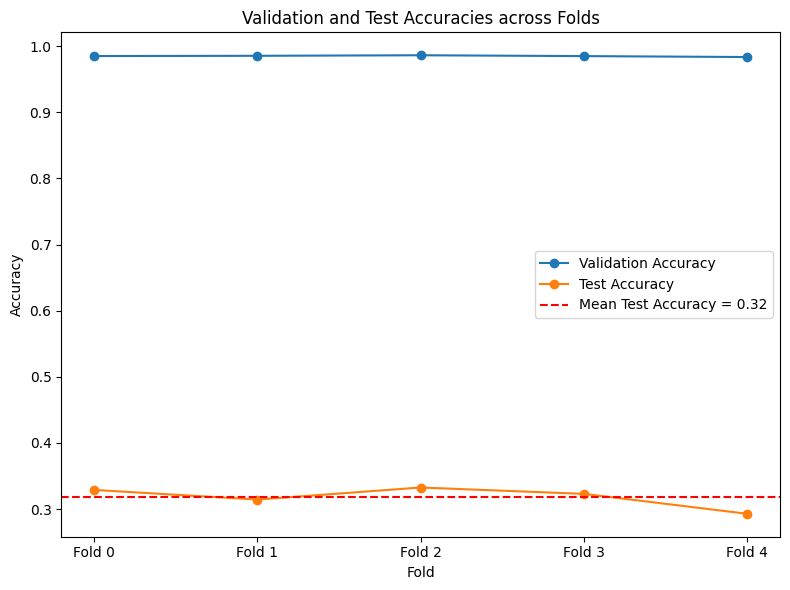

In [ ]:
n_folds = len(acc_val_list)
folds_range = list(range(n_folds))  # e.g., [0, 1, 2, ..., n_folds-1]

plt.figure(figsize=(8, 6))
plt.plot(folds_range, acc_val_list, marker='o', linestyle='-', label='Validation Accuracy')
plt.plot(folds_range, acc_test_list, marker='o', linestyle='-', label='Test Accuracy')

# Compute and plot the mean test accuracy as a dashed line
mean_test = np.mean(acc_test_list)
plt.axhline(y=mean_test, color='red', linestyle='--', label=f'Mean Test Accuracy = {mean_test:.2f}')

plt.xticks(folds_range, [f"Fold {i}" for i in folds_range])
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Validation and Test Accuracies across Folds")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_across_folds.pdf", format="pdf", dpi=300)
plt.show()